### DCGAN 
A GAN constsit of two adversaries , generator and discriminator batteling eachother. The generator converts random noise into data that looks like sample from original dataset and discriminator tries to predict whether the observation comes from original dataset or not. 

In [3]:
%load_ext autoreload 
%autoreload 2 
import numpy as np 
import matplotlib.pyplot as plt 

import tensorflow as tf 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from utils import display, sample_batch

2023-07-19 03:59:36.521339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 03:59:36.670184: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-19 03:59:36.730413: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-19 03:59:37.350481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1 Physical GPUs, 1 Logical GPUs


2023-07-19 03:59:38.421166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.458059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.458216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 03:59:38.459680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

### PARAMETERS

In [4]:
IMAGE_SIZE = 64 
CHANNELS = 1 
BATCH_SIZE = 128 
Z_DIM = 100 
EPOCHS = 300 
LOAD_MODEL = False 
ADAM_BETA_1 = 0.5 
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1 

### PREPARE THE DATA 

In [6]:
train_data = utils.image_dataset_from_directory(
    "../data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE, 
    shuffle=True,
    seed = 42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [7]:
#we use [-1,1] for rescaling data so that we can use tanh activation function on the final layer of the generator , which provides strong
#gradients than the sigmoid function
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img,"float32")-127.5) / 127.5
    return img 
train = train_data.map(lambda x: preprocess(x)

In [8]:
train_sample = sample_batch(train)

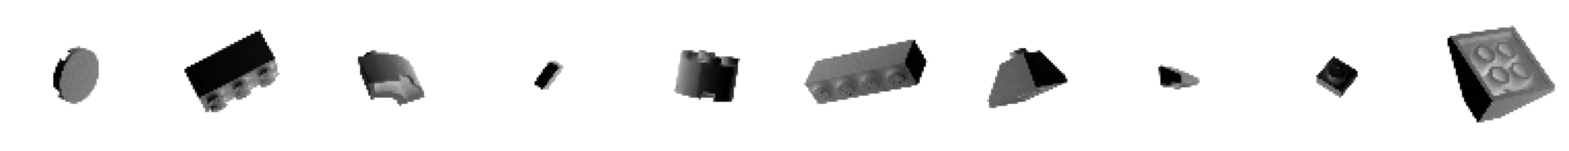

In [9]:
display(train_sample)

### The Discriminator

The goal is to predict if the image is real or fake  which is supervised image classification problem 

In [11]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

x = layers.Conv2D(64,kernel_size=4, strides=2, padding="same",use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2,padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256,kernel_size=4, strides=2, padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                           

### The Generator 
The generator will be converting a vector from multivariate normal distribution to the image of the same size contained in the original training data

In [12]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1,1,Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides = 2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)

x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides= 2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_6 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 128)        1048

Training a discriminator: 
- Get the images from generator as input as get their prediction and calculate loss , since label for generated image is 0 
- Get original images as input for generator and calculate loss , here label will be 1 
- run optimizer on average of these two losses 

Training a Generator :
- generate the fake image from random noise and pass it to the discriminator and caclulate loss between prediction and real images labels

In [13]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [15]:
#Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [17]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

In [21]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE,beta_1 = ADAM_BETA_1, beta_2 = ADAM_BETA_2),
    g_optimizer = optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [19]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/300


2023-07-19 06:11:08.985978: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-07-19 06:11:09.022720: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


313/313 [==============================] - ETA: 0s - d_loss: 0.1353 - d_real_acc: 0.8700 - d_fake_acc: 0.8882 - d_acc: 0.8791 - g_loss: 4.6487 - g_acc: 0.1118
Saved to ./output/generated_img_000.png


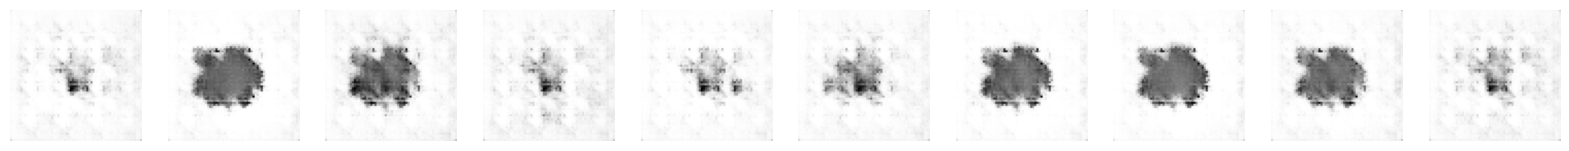

313/313 [==============================] - 62s 156ms/step - d_loss: 0.1353 - d_real_acc: 0.8700 - d_fake_acc: 0.8882 - d_acc: 0.8791 - g_loss: 4.6487 - g_acc: 0.1118
Epoch 2/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0565 - d_real_acc: 0.9168 - d_fake_acc: 0.9315 - d_acc: 0.9241 - g_loss: 6.3705 - g_acc: 0.0685
Saved to ./output/generated_img_001.png


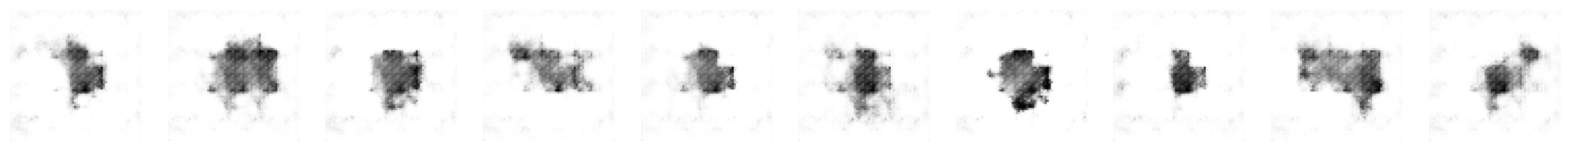

313/313 [==============================] - 45s 142ms/step - d_loss: -0.0565 - d_real_acc: 0.9168 - d_fake_acc: 0.9315 - d_acc: 0.9241 - g_loss: 6.3705 - g_acc: 0.0685
Epoch 3/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0184 - d_real_acc: 0.9003 - d_fake_acc: 0.9057 - d_acc: 0.9030 - g_loss: 5.8926 - g_acc: 0.0943
Saved to ./output/generated_img_002.png


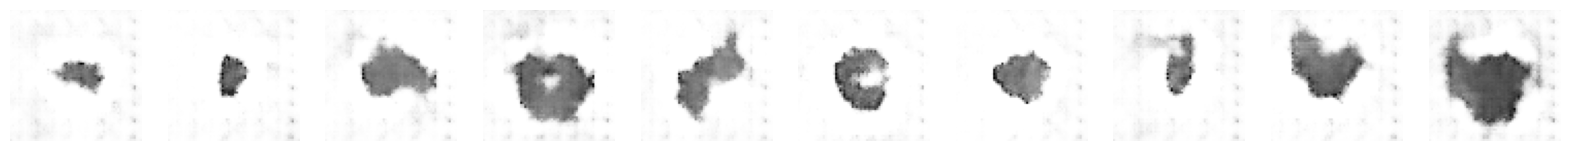

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0184 - d_real_acc: 0.9003 - d_fake_acc: 0.9057 - d_acc: 0.9030 - g_loss: 5.8926 - g_acc: 0.0943
Epoch 4/300
313/313 [==============================] - ETA: 0s - d_loss: 0.1194 - d_real_acc: 0.8843 - d_fake_acc: 0.8832 - d_acc: 0.8838 - g_loss: 5.0984 - g_acc: 0.1168
Saved to ./output/generated_img_003.png


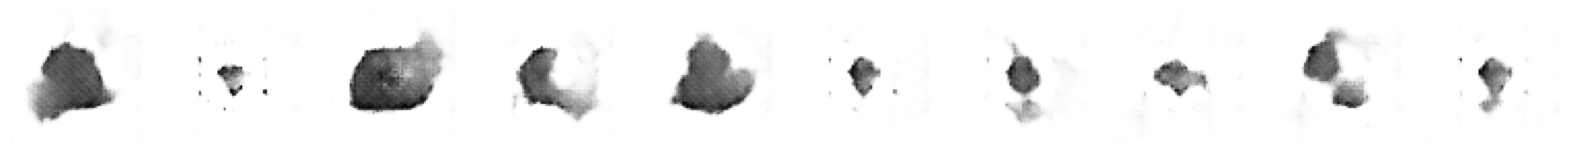

313/313 [==============================] - 45s 142ms/step - d_loss: 0.1194 - d_real_acc: 0.8843 - d_fake_acc: 0.8832 - d_acc: 0.8838 - g_loss: 5.0984 - g_acc: 0.1168
Epoch 5/300
313/313 [==============================] - ETA: 0s - d_loss: 0.1191 - d_real_acc: 0.8839 - d_fake_acc: 0.8887 - d_acc: 0.8863 - g_loss: 4.3839 - g_acc: 0.1113
Saved to ./output/generated_img_004.png


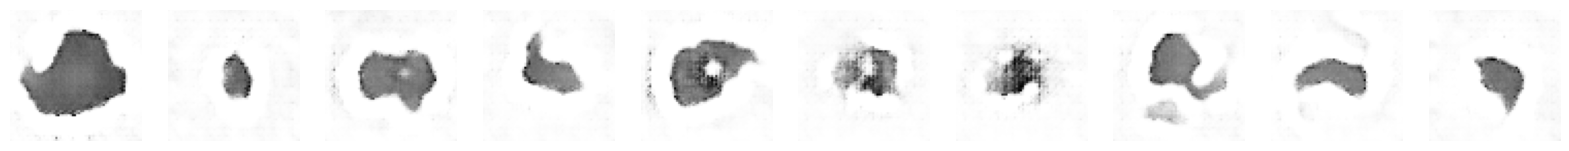

313/313 [==============================] - 45s 142ms/step - d_loss: 0.1191 - d_real_acc: 0.8839 - d_fake_acc: 0.8887 - d_acc: 0.8863 - g_loss: 4.3839 - g_acc: 0.1113
Epoch 6/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0491 - d_real_acc: 0.9012 - d_fake_acc: 0.9035 - d_acc: 0.9023 - g_loss: 4.6111 - g_acc: 0.0965
Saved to ./output/generated_img_005.png


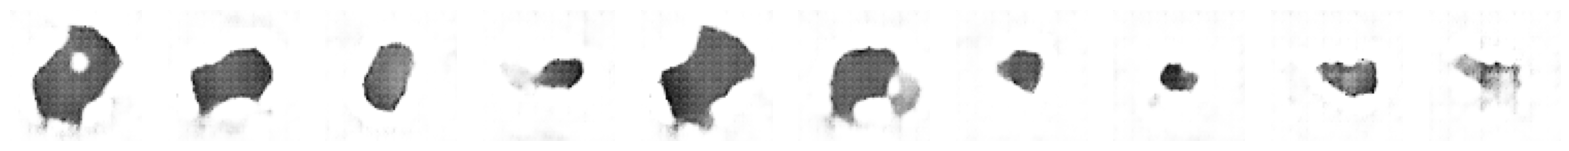

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0491 - d_real_acc: 0.9012 - d_fake_acc: 0.9035 - d_acc: 0.9023 - g_loss: 4.6111 - g_acc: 0.0965
Epoch 7/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0386 - d_real_acc: 0.9003 - d_fake_acc: 0.9030 - d_acc: 0.9016 - g_loss: 4.8193 - g_acc: 0.0970
Saved to ./output/generated_img_006.png


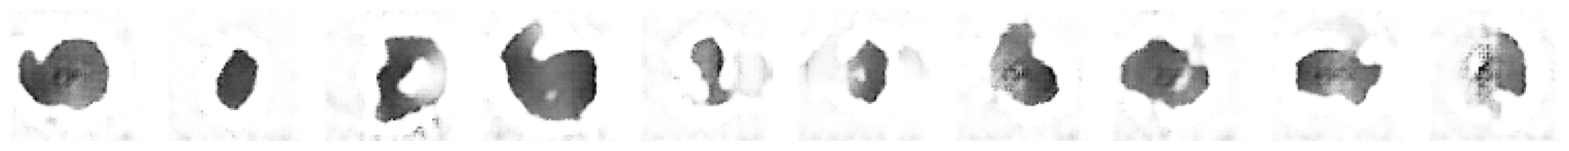

313/313 [==============================] - 45s 142ms/step - d_loss: 0.0386 - d_real_acc: 0.9003 - d_fake_acc: 0.9030 - d_acc: 0.9016 - g_loss: 4.8193 - g_acc: 0.0970
Epoch 8/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0891 - d_real_acc: 0.8894 - d_fake_acc: 0.8920 - d_acc: 0.8907 - g_loss: 4.9339 - g_acc: 0.1080
Saved to ./output/generated_img_007.png


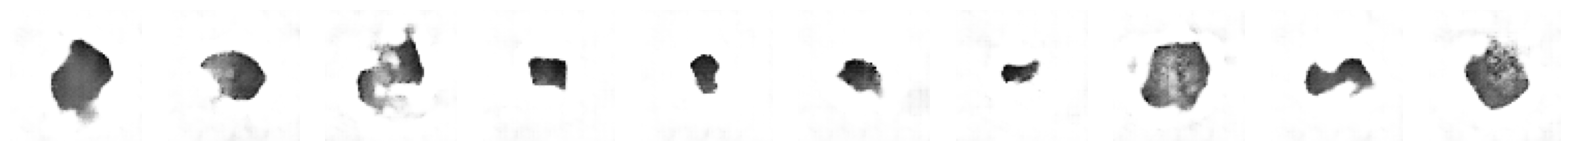

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0891 - d_real_acc: 0.8894 - d_fake_acc: 0.8920 - d_acc: 0.8907 - g_loss: 4.9339 - g_acc: 0.1080
Epoch 9/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0175 - d_real_acc: 0.9079 - d_fake_acc: 0.9105 - d_acc: 0.9092 - g_loss: 5.0815 - g_acc: 0.0895
Saved to ./output/generated_img_008.png


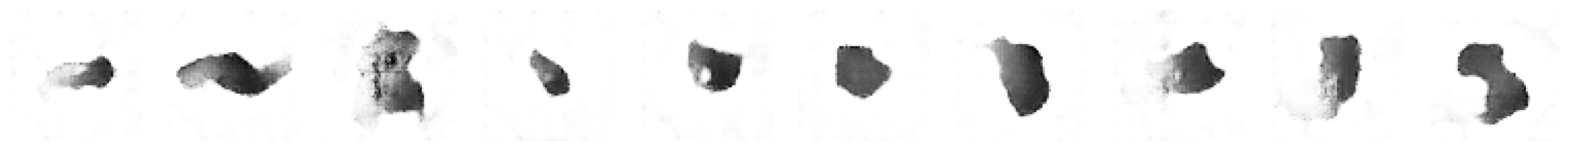

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0175 - d_real_acc: 0.9079 - d_fake_acc: 0.9105 - d_acc: 0.9092 - g_loss: 5.0815 - g_acc: 0.0895
Epoch 10/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0948 - d_real_acc: 0.9041 - d_fake_acc: 0.9017 - d_acc: 0.9029 - g_loss: 4.9723 - g_acc: 0.0983
Saved to ./output/generated_img_009.png


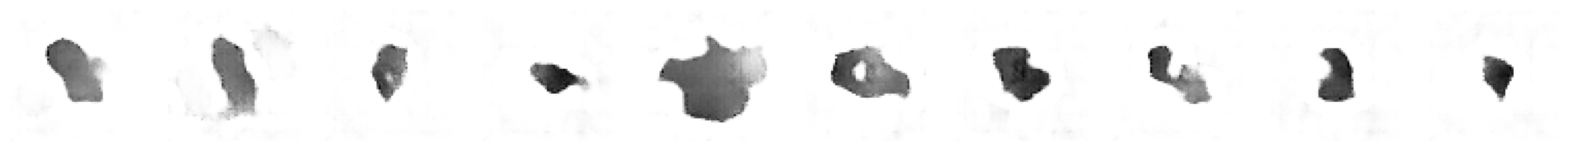

313/313 [==============================] - 45s 142ms/step - d_loss: 0.0948 - d_real_acc: 0.9041 - d_fake_acc: 0.9017 - d_acc: 0.9029 - g_loss: 4.9723 - g_acc: 0.0983
Epoch 11/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0143 - d_real_acc: 0.9148 - d_fake_acc: 0.9175 - d_acc: 0.9161 - g_loss: 5.1220 - g_acc: 0.0825
Saved to ./output/generated_img_010.png


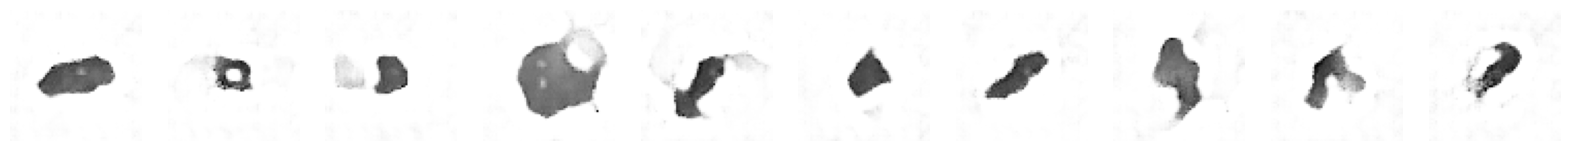

313/313 [==============================] - 45s 144ms/step - d_loss: 0.0143 - d_real_acc: 0.9148 - d_fake_acc: 0.9175 - d_acc: 0.9161 - g_loss: 5.1220 - g_acc: 0.0825
Epoch 12/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0083 - d_real_acc: 0.9122 - d_fake_acc: 0.9150 - d_acc: 0.9136 - g_loss: 5.4300 - g_acc: 0.0850
Saved to ./output/generated_img_011.png


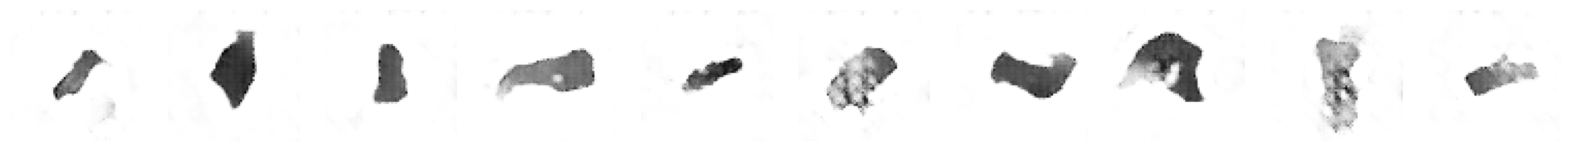

313/313 [==============================] - 45s 144ms/step - d_loss: 0.0083 - d_real_acc: 0.9122 - d_fake_acc: 0.9150 - d_acc: 0.9136 - g_loss: 5.4300 - g_acc: 0.0850
Epoch 13/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0896 - d_real_acc: 0.9011 - d_fake_acc: 0.9050 - d_acc: 0.9031 - g_loss: 5.1292 - g_acc: 0.0949
Saved to ./output/generated_img_012.png


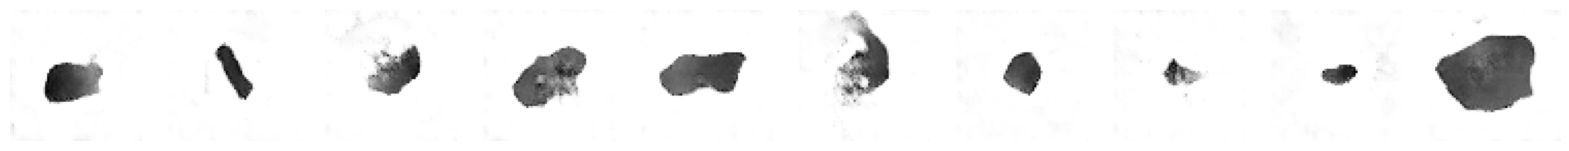

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0896 - d_real_acc: 0.9011 - d_fake_acc: 0.9050 - d_acc: 0.9031 - g_loss: 5.1292 - g_acc: 0.0949
Epoch 14/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0633 - d_real_acc: 0.9360 - d_fake_acc: 0.9355 - d_acc: 0.9358 - g_loss: 5.8460 - g_acc: 0.0645
Saved to ./output/generated_img_013.png


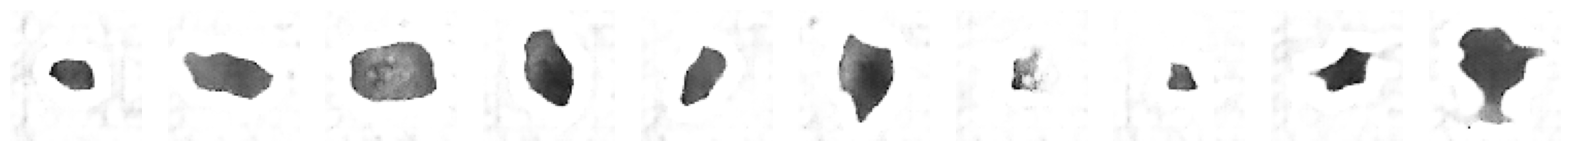

313/313 [==============================] - 45s 144ms/step - d_loss: -0.0633 - d_real_acc: 0.9360 - d_fake_acc: 0.9355 - d_acc: 0.9358 - g_loss: 5.8460 - g_acc: 0.0645
Epoch 15/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0717 - d_real_acc: 0.9011 - d_fake_acc: 0.8996 - d_acc: 0.9004 - g_loss: 5.5371 - g_acc: 0.1004
Saved to ./output/generated_img_014.png


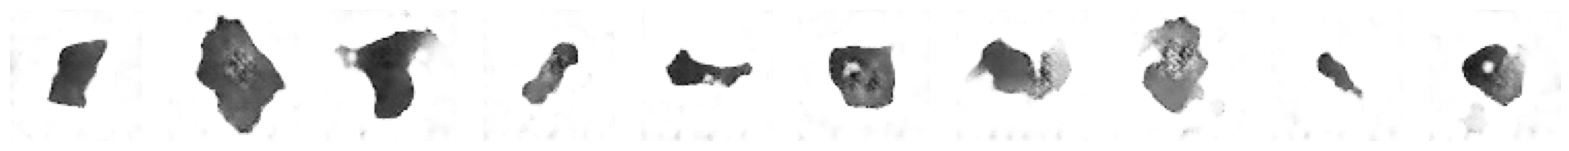

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0717 - d_real_acc: 0.9011 - d_fake_acc: 0.8996 - d_acc: 0.9004 - g_loss: 5.5371 - g_acc: 0.1004
Epoch 16/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0252 - d_real_acc: 0.9266 - d_fake_acc: 0.9292 - d_acc: 0.9279 - g_loss: 6.0639 - g_acc: 0.0708
Saved to ./output/generated_img_015.png


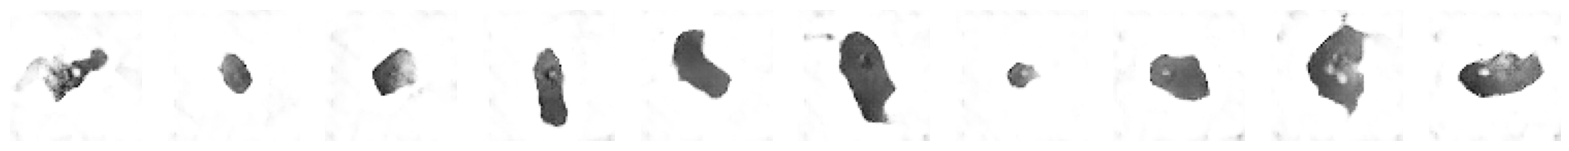

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0252 - d_real_acc: 0.9266 - d_fake_acc: 0.9292 - d_acc: 0.9279 - g_loss: 6.0639 - g_acc: 0.0708
Epoch 17/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0297 - d_real_acc: 0.9177 - d_fake_acc: 0.9176 - d_acc: 0.9177 - g_loss: 6.1070 - g_acc: 0.0824
Saved to ./output/generated_img_016.png


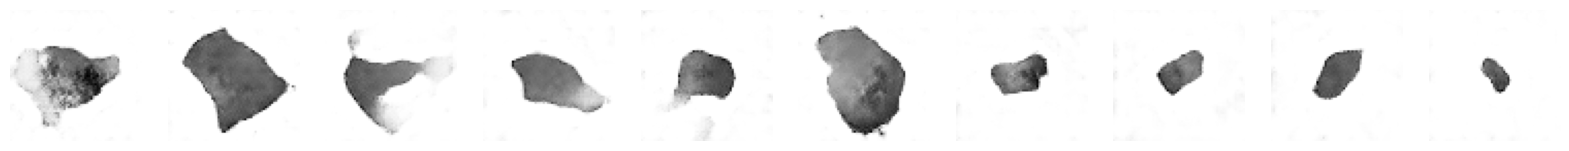

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0297 - d_real_acc: 0.9177 - d_fake_acc: 0.9176 - d_acc: 0.9177 - g_loss: 6.1070 - g_acc: 0.0824
Epoch 18/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0842 - d_real_acc: 0.9385 - d_fake_acc: 0.9410 - d_acc: 0.9398 - g_loss: 6.1774 - g_acc: 0.0589
Saved to ./output/generated_img_017.png


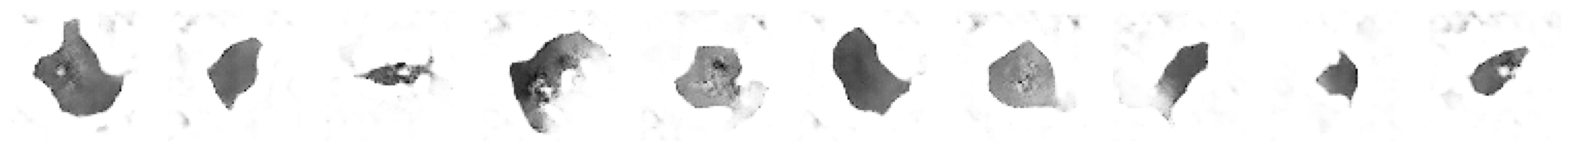

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0842 - d_real_acc: 0.9385 - d_fake_acc: 0.9410 - d_acc: 0.9398 - g_loss: 6.1774 - g_acc: 0.0589
Epoch 19/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0614 - d_real_acc: 0.9367 - d_fake_acc: 0.9360 - d_acc: 0.9364 - g_loss: 6.3243 - g_acc: 0.0640
Saved to ./output/generated_img_018.png


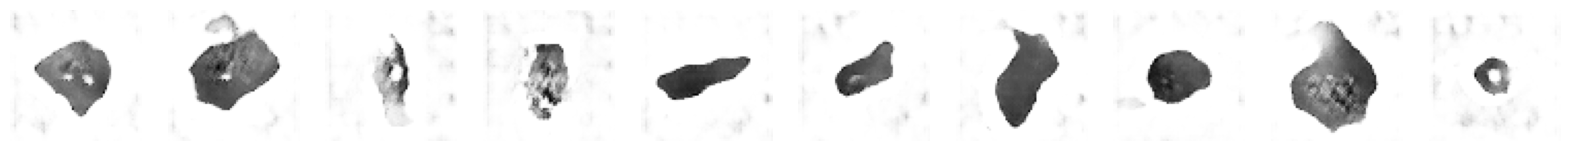

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0614 - d_real_acc: 0.9367 - d_fake_acc: 0.9360 - d_acc: 0.9364 - g_loss: 6.3243 - g_acc: 0.0640
Epoch 20/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0746 - d_real_acc: 0.9344 - d_fake_acc: 0.9351 - d_acc: 0.9347 - g_loss: 6.5665 - g_acc: 0.0649
Saved to ./output/generated_img_019.png


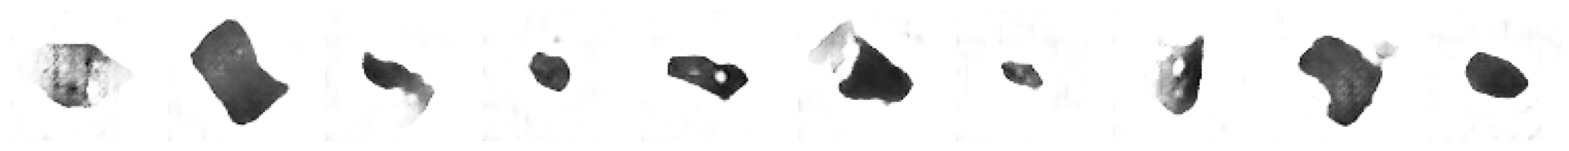

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0746 - d_real_acc: 0.9344 - d_fake_acc: 0.9351 - d_acc: 0.9347 - g_loss: 6.5665 - g_acc: 0.0649
Epoch 21/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1179 - d_real_acc: 0.9388 - d_fake_acc: 0.9409 - d_acc: 0.9399 - g_loss: 6.6405 - g_acc: 0.0591
Saved to ./output/generated_img_020.png


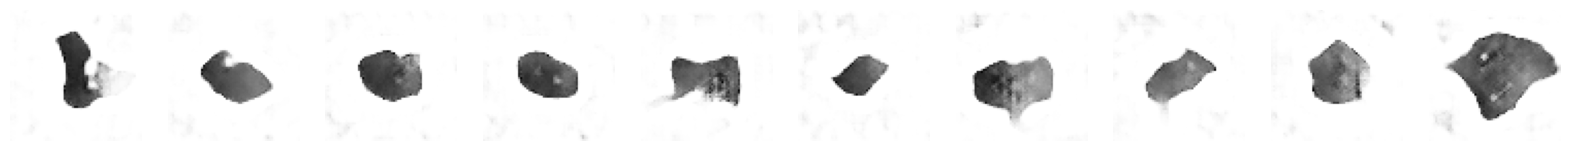

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1179 - d_real_acc: 0.9388 - d_fake_acc: 0.9409 - d_acc: 0.9399 - g_loss: 6.6405 - g_acc: 0.0591
Epoch 22/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1209 - d_real_acc: 0.9416 - d_fake_acc: 0.9419 - d_acc: 0.9417 - g_loss: 7.0521 - g_acc: 0.0581
Saved to ./output/generated_img_021.png


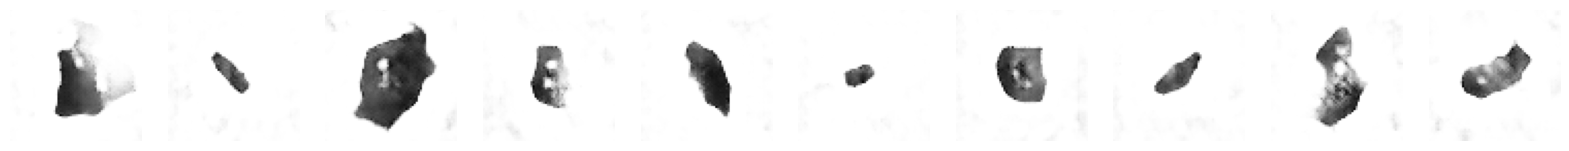

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1209 - d_real_acc: 0.9416 - d_fake_acc: 0.9419 - d_acc: 0.9417 - g_loss: 7.0521 - g_acc: 0.0581
Epoch 23/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1874 - d_real_acc: 0.9580 - d_fake_acc: 0.9603 - d_acc: 0.9592 - g_loss: 7.4210 - g_acc: 0.0397
Saved to ./output/generated_img_022.png


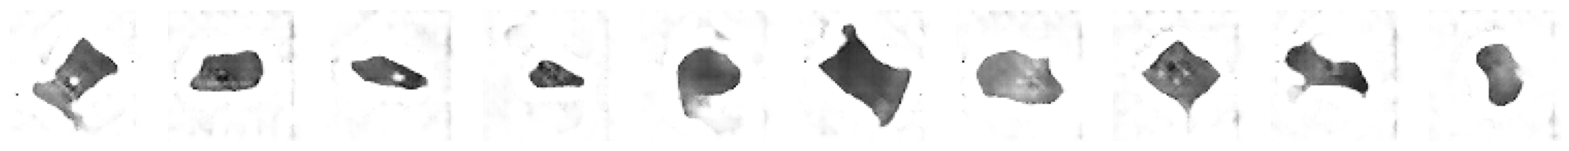

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1874 - d_real_acc: 0.9580 - d_fake_acc: 0.9603 - d_acc: 0.9592 - g_loss: 7.4210 - g_acc: 0.0397
Epoch 24/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1557 - d_real_acc: 0.9449 - d_fake_acc: 0.9442 - d_acc: 0.9446 - g_loss: 7.5504 - g_acc: 0.0558
Saved to ./output/generated_img_023.png


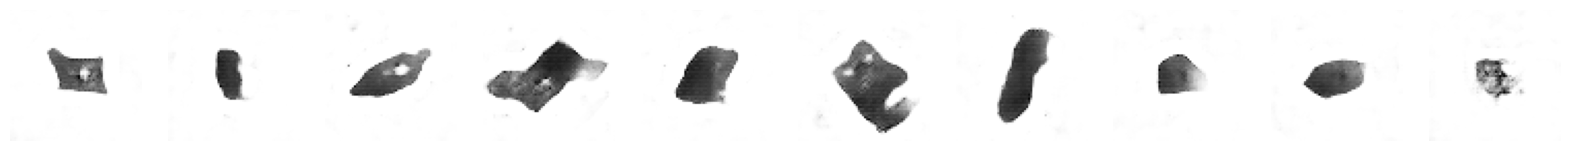

313/313 [==============================] - 45s 144ms/step - d_loss: -0.1557 - d_real_acc: 0.9449 - d_fake_acc: 0.9442 - d_acc: 0.9446 - g_loss: 7.5504 - g_acc: 0.0558
Epoch 25/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1511 - d_real_acc: 0.9427 - d_fake_acc: 0.9455 - d_acc: 0.9441 - g_loss: 7.5599 - g_acc: 0.0545
Saved to ./output/generated_img_024.png


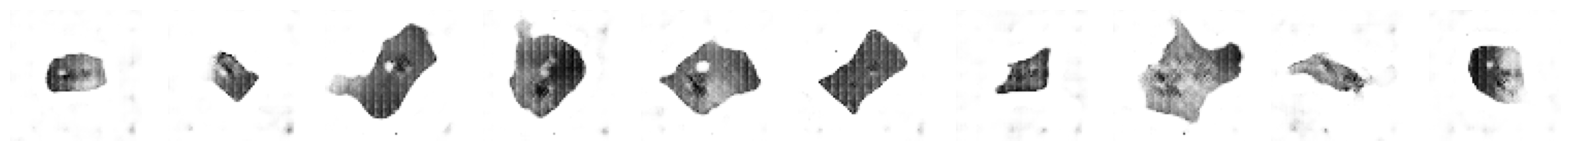

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1511 - d_real_acc: 0.9427 - d_fake_acc: 0.9455 - d_acc: 0.9441 - g_loss: 7.5599 - g_acc: 0.0545
Epoch 26/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0318 - d_real_acc: 0.9146 - d_fake_acc: 0.9197 - d_acc: 0.9171 - g_loss: 7.5281 - g_acc: 0.0803
Saved to ./output/generated_img_025.png


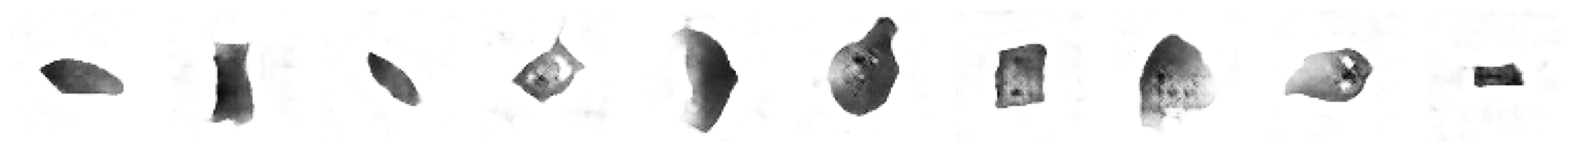

313/313 [==============================] - 45s 143ms/step - d_loss: 0.0318 - d_real_acc: 0.9146 - d_fake_acc: 0.9197 - d_acc: 0.9171 - g_loss: 7.5281 - g_acc: 0.0803
Epoch 27/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1789 - d_real_acc: 0.9467 - d_fake_acc: 0.9473 - d_acc: 0.9470 - g_loss: 8.0894 - g_acc: 0.0527
Saved to ./output/generated_img_026.png


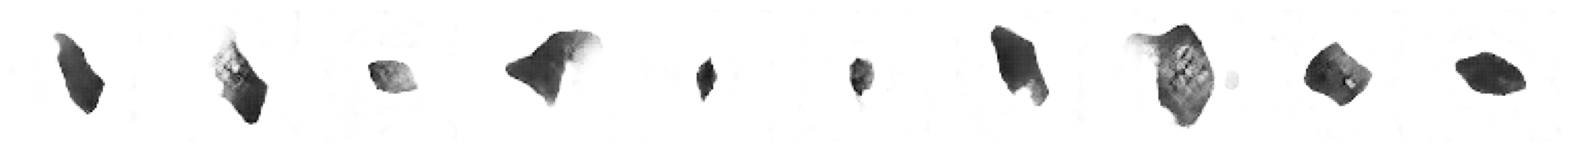

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1789 - d_real_acc: 0.9467 - d_fake_acc: 0.9473 - d_acc: 0.9470 - g_loss: 8.0894 - g_acc: 0.0527
Epoch 28/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0515 - d_real_acc: 0.9220 - d_fake_acc: 0.9239 - d_acc: 0.9229 - g_loss: 7.3165 - g_acc: 0.0761
Saved to ./output/generated_img_027.png


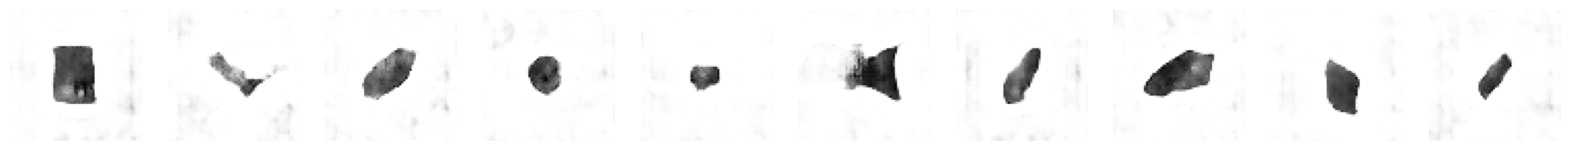

313/313 [==============================] - 45s 144ms/step - d_loss: -0.0515 - d_real_acc: 0.9220 - d_fake_acc: 0.9239 - d_acc: 0.9229 - g_loss: 7.3165 - g_acc: 0.0761
Epoch 29/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1569 - d_real_acc: 0.9498 - d_fake_acc: 0.9575 - d_acc: 0.9536 - g_loss: 8.2665 - g_acc: 0.0425
Saved to ./output/generated_img_028.png


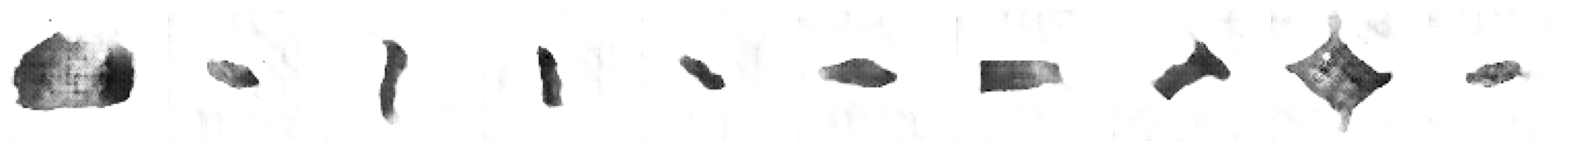

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1569 - d_real_acc: 0.9498 - d_fake_acc: 0.9575 - d_acc: 0.9536 - g_loss: 8.2665 - g_acc: 0.0425
Epoch 30/300
313/313 [==============================] - ETA: 0s - d_loss: 0.0661 - d_real_acc: 0.9116 - d_fake_acc: 0.9188 - d_acc: 0.9152 - g_loss: 7.6632 - g_acc: 0.0812
Saved to ./output/generated_img_029.png


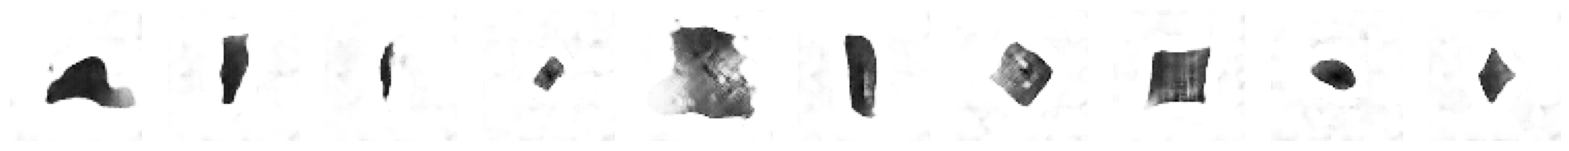

313/313 [==============================] - 45s 144ms/step - d_loss: 0.0661 - d_real_acc: 0.9116 - d_fake_acc: 0.9188 - d_acc: 0.9152 - g_loss: 7.6632 - g_acc: 0.0812
Epoch 31/300
313/313 [==============================] - ETA: 0s - d_loss: -0.2405 - d_real_acc: 0.9531 - d_fake_acc: 0.9535 - d_acc: 0.9533 - g_loss: 8.4430 - g_acc: 0.0465
Saved to ./output/generated_img_030.png


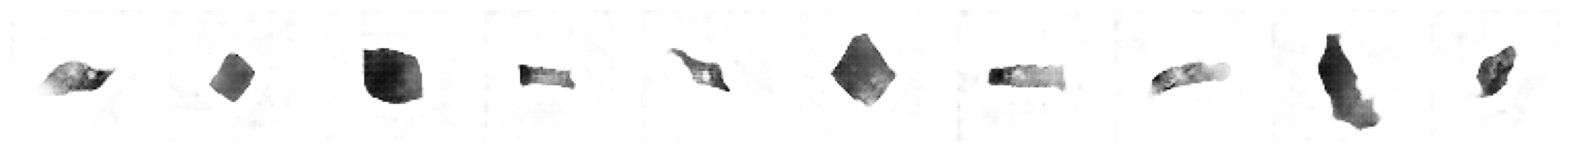

313/313 [==============================] - 46s 145ms/step - d_loss: -0.2405 - d_real_acc: 0.9531 - d_fake_acc: 0.9535 - d_acc: 0.9533 - g_loss: 8.4430 - g_acc: 0.0465
Epoch 32/300
313/313 [==============================] - ETA: 0s - d_loss: -0.2220 - d_real_acc: 0.9488 - d_fake_acc: 0.9498 - d_acc: 0.9493 - g_loss: 8.7881 - g_acc: 0.0502
Saved to ./output/generated_img_031.png


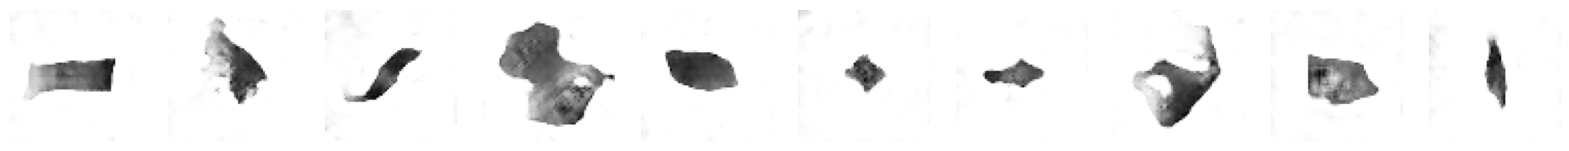

313/313 [==============================] - 45s 143ms/step - d_loss: -0.2220 - d_real_acc: 0.9488 - d_fake_acc: 0.9498 - d_acc: 0.9493 - g_loss: 8.7881 - g_acc: 0.0502
Epoch 33/300
313/313 [==============================] - ETA: 0s - d_loss: -0.6994 - d_real_acc: 0.9986 - d_fake_acc: 0.9981 - d_acc: 0.9983 - g_loss: 14.2370 - g_acc: 0.0019
Saved to ./output/generated_img_032.png


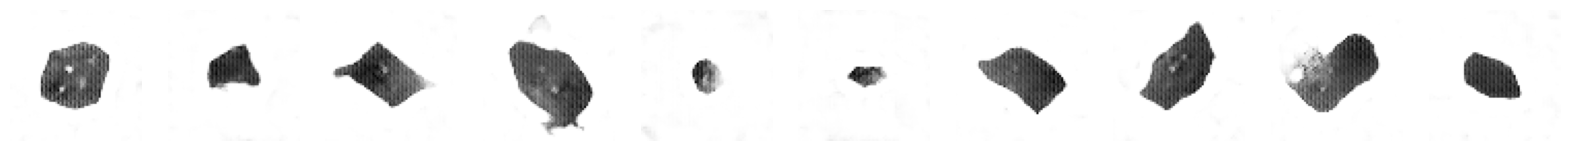

313/313 [==============================] - 44s 141ms/step - d_loss: -0.6994 - d_real_acc: 0.9986 - d_fake_acc: 0.9981 - d_acc: 0.9983 - g_loss: 14.2370 - g_acc: 0.0019
Epoch 34/300
313/313 [==============================] - ETA: 0s - d_loss: -0.5418 - d_real_acc: 0.9737 - d_fake_acc: 0.9706 - d_acc: 0.9721 - g_loss: 13.9423 - g_acc: 0.0294
Saved to ./output/generated_img_033.png


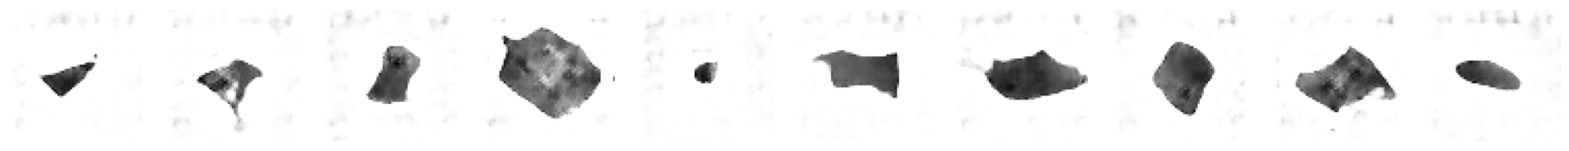

313/313 [==============================] - 45s 141ms/step - d_loss: -0.5418 - d_real_acc: 0.9737 - d_fake_acc: 0.9706 - d_acc: 0.9721 - g_loss: 13.9423 - g_acc: 0.0294
Epoch 35/300
313/313 [==============================] - ETA: 0s - d_loss: -0.0360 - d_real_acc: 0.9186 - d_fake_acc: 0.9346 - d_acc: 0.9266 - g_loss: 8.6906 - g_acc: 0.0654
Saved to ./output/generated_img_034.png


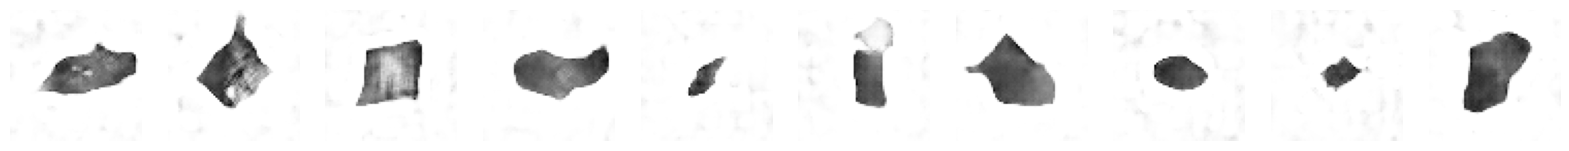

313/313 [==============================] - 45s 143ms/step - d_loss: -0.0360 - d_real_acc: 0.9186 - d_fake_acc: 0.9346 - d_acc: 0.9266 - g_loss: 8.6906 - g_acc: 0.0654
Epoch 36/300
313/313 [==============================] - ETA: 0s - d_loss: -0.3560 - d_real_acc: 0.9647 - d_fake_acc: 0.9665 - d_acc: 0.9656 - g_loss: 9.7504 - g_acc: 0.0335
Saved to ./output/generated_img_035.png


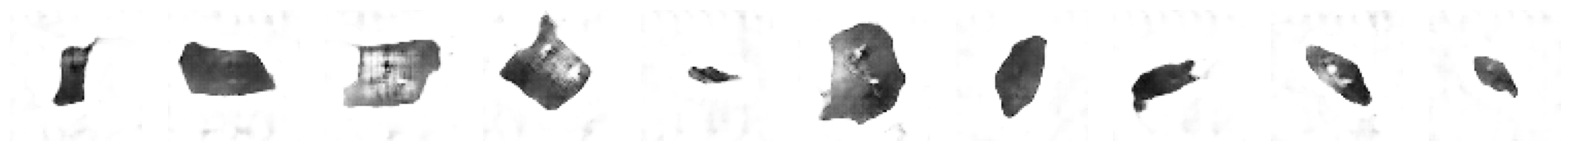

313/313 [==============================] - 45s 143ms/step - d_loss: -0.3560 - d_real_acc: 0.9647 - d_fake_acc: 0.9665 - d_acc: 0.9656 - g_loss: 9.7504 - g_acc: 0.0335
Epoch 37/300
313/313 [==============================] - ETA: 0s - d_loss: -0.1518 - d_real_acc: 0.9357 - d_fake_acc: 0.9384 - d_acc: 0.9370 - g_loss: 8.4061 - g_acc: 0.0616
Saved to ./output/generated_img_036.png


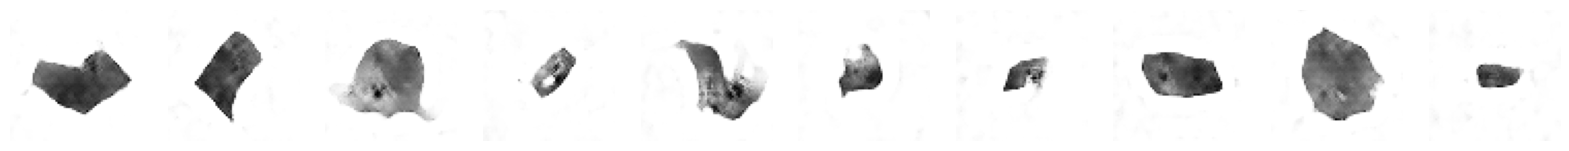

313/313 [==============================] - 45s 143ms/step - d_loss: -0.1518 - d_real_acc: 0.9357 - d_fake_acc: 0.9384 - d_acc: 0.9370 - g_loss: 8.4061 - g_acc: 0.0616
Epoch 38/300
313/313 [==============================] - ETA: 0s - d_loss: -0.2920 - d_real_acc: 0.9536 - d_fake_acc: 0.9555 - d_acc: 0.9545 - g_loss: 9.7957 - g_acc: 0.0445
Saved to ./output/generated_img_037.png


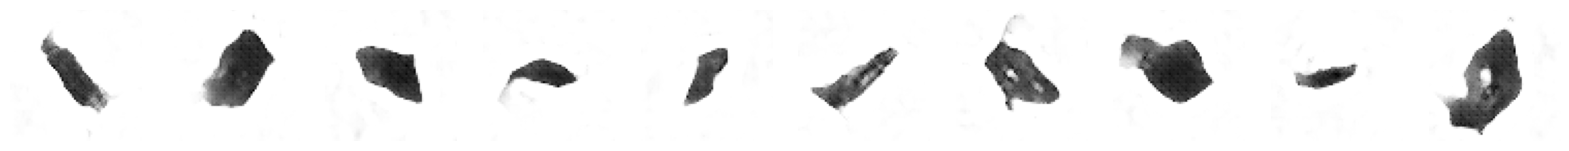

313/313 [==============================] - 45s 143ms/step - d_loss: -0.2920 - d_real_acc: 0.9536 - d_fake_acc: 0.9555 - d_acc: 0.9545 - g_loss: 9.7957 - g_acc: 0.0445
Epoch 39/300
313/313 [==============================] - ETA: 0s - d_loss: -0.7516 - d_real_acc: 0.9992 - d_fake_acc: 0.9991 - d_acc: 0.9992 - g_loss: 15.1185 - g_acc: 9.0000e-04
Saved to ./output/generated_img_038.png


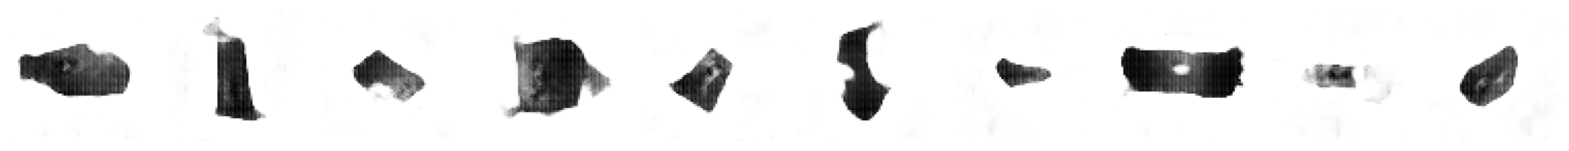

313/313 [==============================] - 45s 141ms/step - d_loss: -0.7516 - d_real_acc: 0.9992 - d_fake_acc: 0.9991 - d_acc: 0.9992 - g_loss: 15.1185 - g_acc: 9.0000e-04
Epoch 40/300
313/313 [==============================] - ETA: 0s - d_loss: 5.9236 - d_real_acc: 0.2133 - d_fake_acc: 0.9960 - d_acc: 0.6047 - g_loss: 15.2274 - g_acc: 0.0040
Saved to ./output/generated_img_039.png


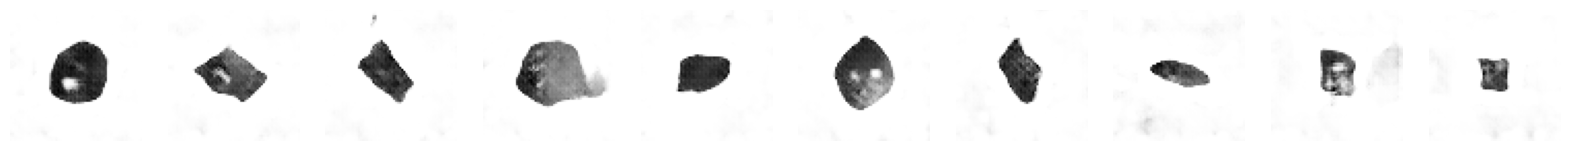

313/313 [==============================] - 44s 140ms/step - d_loss: 5.9236 - d_real_acc: 0.2133 - d_fake_acc: 0.9960 - d_acc: 0.6047 - g_loss: 15.2274 - g_acc: 0.0040
Epoch 41/300
313/313 [==============================] - ETA: 0s - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_040.png


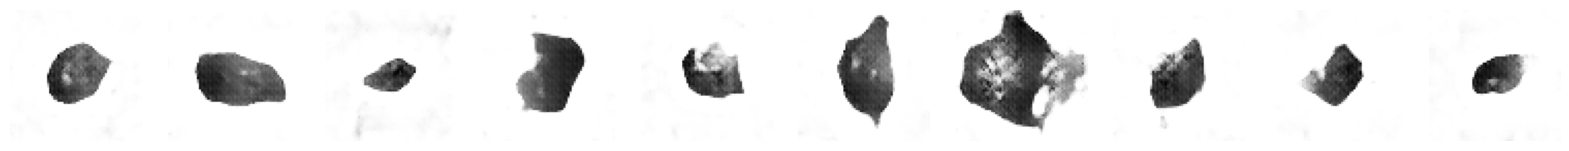

313/313 [==============================] - 44s 140ms/step - d_loss: 7.7127 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 42/300
313/313 [==============================] - ETA: 0s - d_loss: 7.7132 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_041.png


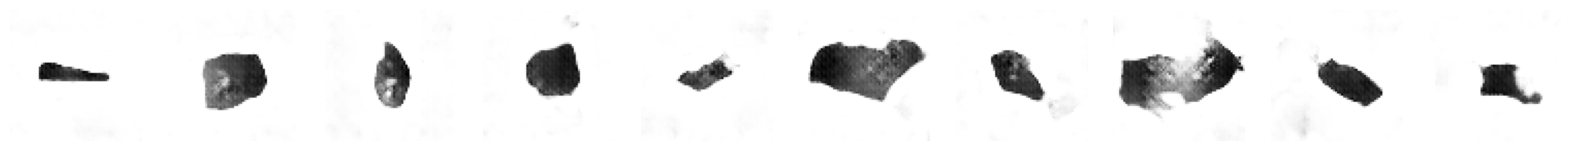

313/313 [==============================] - 44s 139ms/step - d_loss: 7.7132 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 43/300
313/313 [==============================] - ETA: 0s - d_loss: 7.7122 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_042.png


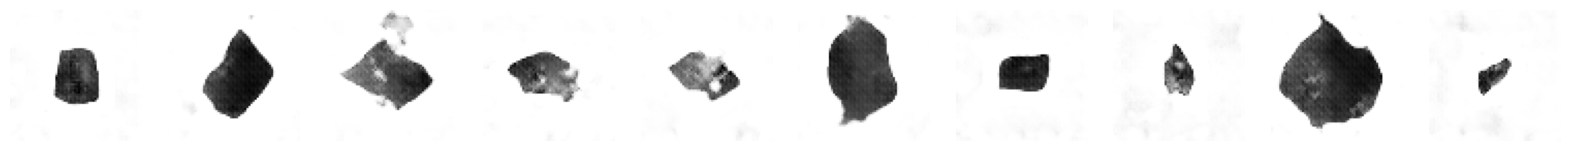

313/313 [==============================] - 44s 140ms/step - d_loss: 7.7122 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 44/300
313/313 [==============================] - ETA: 0s - d_loss: 7.7148 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_043.png


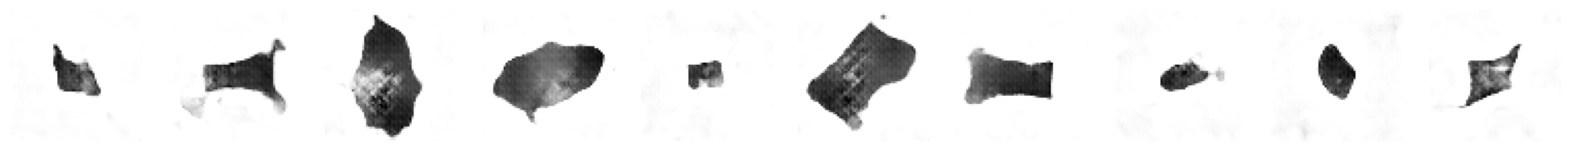

313/313 [==============================] - 44s 139ms/step - d_loss: 7.7148 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 45/300
283/313 [==========================>...] - ETA: 4s - d_loss: 7.7118 - d_real_acc: 0.0000e+00 - d_fake_acc: 1.0000 - d_acc: 0.5000 - g_loss: 15.4250 - g_acc: 0.0000e+00

In [ ]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks = [
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
#save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

### Generate New images 

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

### Problems with GAN
- The loss obtained from the generator is only evaluated against current instance of discriminator so evaluating the loss cannot be done 
- Terminology called 'mode collapse" where the generator is biased toward finding a single instance of obsevation that can always fool discriminator
- GANs are highly sensitive toward slight change in hyperparameters
- either discriminator or generator power one another as a result, we cannot come to equilibrium 
